Making a LeNet 5 CNN Model on Fashion MNIST Dataset using Pytorch

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
training=datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
testing=datasets.FashionMNIST(root="data",train=False,download=True,transform=ToTensor())

In [3]:
train_dataloader=DataLoader(training,batch_size=64)
test_dataloader=DataLoader(testing,batch_size=64)

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)
        self.s2=nn.AvgPool2d(kernel_size=2,stride=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.s4=nn.AvgPool2d(kernel_size=2,stride=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1)
        self.flatten= nn.Flatten(start_dim=1)
        self.l1=nn.Linear(in_features=120,out_features=84)
        self.l2=nn.Linear(in_features=84,out_features=10)
        self.act=nn.Tanh()
    def forward(self,x):
        x=self.c1(x)
        x=self.act(x)
        x=self.s2(x)
        x=self.c3(x)
        x=self.act(x)
        x=self.s4(x)
        x=self.c5(x)
        x=self.act(x)
        x=self.flatten(x)
        x=self.l1(x)
        x=self.act(x)
        x=self.l2(x)
        return x
        
    



In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model=NeuralNetwork().to(device)
learning_rate=0.001


In [7]:
loss_fun=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [8]:
def accuracy_check(loader,model):
    correct=0
    total=0
    model.eval()
    with torch.no_grad():
        for (x,y) in (loader):
            x=x.to(device=device)
            y=y.to(device=device)
            scores=model(x)
            scores=nn.functional.softmax(scores,dim=1)
            _,predictions=scores.max(1)
            correct+=(predictions==y).sum()
            total+= predictions.size(0)
    return float(correct/total)

In [9]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img=img.mean(dim=0)
     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg,cmap="gray")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter('tensor/fashionMNIS')

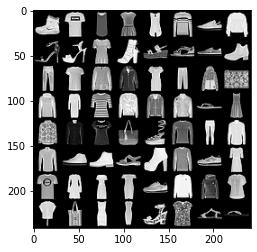

In [11]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()


img_grid = torchvision.utils.make_grid(images)


matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('64_fashion_mnist_images', img_grid)

In [12]:
writer.add_graph(model, images)
writer.close()

In [13]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [14]:
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(training.data, training.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [15]:
def images_to_probs(net, images):
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [16]:
running_loss = 0.0
for epoch in tqdm(range(10)):  # loop over the dataset multiple times

    for i, data in tqdm(enumerate(train_dataloader, 0)):
        inputs, labels = data
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = loss_fun(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        if i % 100 == 99:    # every 100 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_dataloader) + i)
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(train_dataloader) + i)
            writer.add_scalar("Accuracy",accuracy_check(test_dataloader,model),global_step=epoch * len(train_dataloader) + i)
            running_loss = 0.0
print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finished Training


In [17]:
print(accuracy_check(train_dataloader,model))
print(accuracy_check(test_dataloader,model))

In [ ]:
EPOCH = 10
PATH = "model.pt"
LOSS = 0.024

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimiser.state_dict(),
            'loss': LOSS,
            }, PATH)